# Read data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from video_processing import read_video_array
from shm_system import SimpleHarmonicSystem

In [20]:
df = pd.read_csv('data/raw/experimental_data.tsv', sep='\t')
df.columns = ['t', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'unk', 'frame', 'Ek', 'theta']
df = df[['frame','t', 'theta']]

def convert_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        df[col] = df[col].str.replace(',', '.').astype('float')
    return df

df = convert_numeric(df.astype(str))
df['theta'] = np.deg2rad(df['theta'])
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   frame   129 non-null    float64
 1   t       129 non-null    float64
 2   theta   130 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None


,frame,t,theta
0,140.0,0.000,-0.157080
1,141.0,0.041,-0.162316
2,142.0,0.081,-0.158825
3,143.0,0.123,-0.153589
4,144.0,0.166,-0.144862
...,...,...,...
125,265.0,5.214,0.127409
126,266.0,5.262,0.122173
127,267.0,5.302,0.115192
128,269.0,5.385,0.106465


In [21]:
SYS_CONF = dict(
    theta_0=df['theta'].values[0], # rad
    g=9.77, # m / s**2
    m=5.76, # grams
    L=1, # m
    phi=0 # rad
)

In [13]:
def delta(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    d = []
    for i in range(len(y)):
        if i > 0 and None in [y[i], y[i-1]]:
            d.append(np.nan)
            continue
        d.append((y[i] - y[i-1])/(x[i] - x[i-1]))
    d = np.array(d)
    return d

df['velocity'] = delta(y=df['theta'].values, x=df['t'].values)
df['acceleration'] = delta(y=df['velocity'].values, x=df['t'].values)
df['kinetic_energy'] = (1/2) * SYS_CONF['m'] * df['velocity']
df

,frame,t,angle,v,a,k
0,140.0,0.000,-0.157080,NaN,NaN,NaN
1,141.0,0.041,-0.162316,-0.127707,NaN,-0.367796
2,142.0,0.081,-0.158825,0.087266,5.374337,0.251327
3,143.0,0.123,-0.153589,0.124666,0.890474,0.359039
4,144.0,0.166,-0.144862,0.202945,1.820439,0.584482
...,...,...,...,...,...,...
125,265.0,5.214,0.127409,-0.035619,0.121153,-0.102583
126,266.0,5.262,0.122173,-0.109083,-1.530502,-0.314159
127,267.0,5.302,0.115192,-0.174533,-1.636246,-0.502655
128,269.0,5.385,0.106465,-0.105140,0.836056,-0.302804


In [14]:
START_FRAME = 142
END_FRAME = 268
df = df[df['frame'].isin(range(START_FRAME, END_FRAME))]
df

,frame,t,angle,v,a,k
2,142.0,0.081,-0.158825,0.087266,5.374337,0.251327
3,143.0,0.123,-0.153589,0.124666,0.890474,0.359039
4,144.0,0.166,-0.144862,0.202945,1.820439,0.584482
5,145.0,0.208,-0.134390,0.249333,1.104464,0.718078
6,146.0,0.248,-0.122173,0.305433,1.402497,0.879646
...,...,...,...,...,...,...
123,263.0,5.123,0.130900,0.048481,-1.018240,0.139626
124,264.0,5.165,0.129154,-0.041555,-2.143734,-0.119680
125,265.0,5.214,0.127409,-0.035619,0.121153,-0.102583
126,266.0,5.262,0.122173,-0.109083,-1.530502,-0.314159


In [15]:
df.set_index('frame', inplace=True)
df

,t,angle,v,a,k
frame,,,,,
142.0,0.081,-0.158825,0.087266,5.374337,0.251327
143.0,0.123,-0.153589,0.124666,0.890474,0.359039
144.0,0.166,-0.144862,0.202945,1.820439,0.584482
145.0,0.208,-0.134390,0.249333,1.104464,0.718078
146.0,0.248,-0.122173,0.305433,1.402497,0.879646
...,...,...,...,...,...
263.0,5.123,0.130900,0.048481,-1.018240,0.139626
264.0,5.165,0.129154,-0.041555,-2.143734,-0.119680
265.0,5.214,0.127409,-0.035619,0.121153,-0.102583


# Theoretical vs Experimental systems


In [17]:
ts = SimpleHarmonicSystem(**SYS_CONF)
ts.t = df['t'].values

In [18]:
variables = ['velocity', 'acceleration', 'ek', 'eu', 'em']
tdf = pd.DataFrame(index=df.index)
tdf['angle'] = ts.theta
tdf['t'] = ts.t
tdf['v'] = ts.velocity()
tdf['a'] = ts.acceleration()
tdf['k'] = ts.ek()

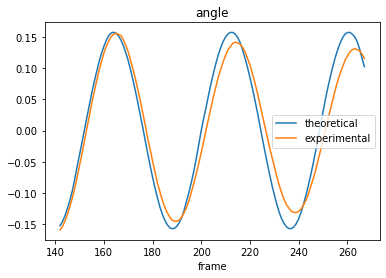

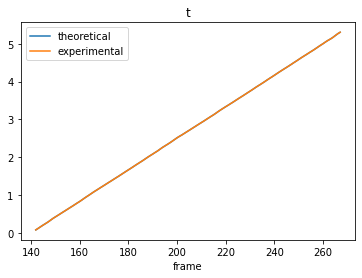

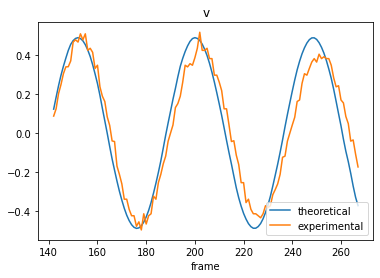

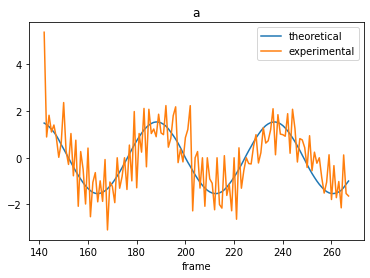

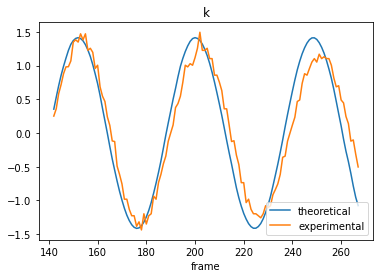

In [19]:
fig, ax = plt.subplots()
for col in tdf.columns:
    tdf[col].plot(label='theoretical')
    df[col].plot(label='experimental')
    plt.legend()
    plt.title(col)
    plt.show()


In [9]:
tdf

,angle,t,velocity,acceleration,ek,eu,em
frame,,,,,,,
143.0,-0.142377,0.123,0.180056,1.391024,0.518561,0.569421,1.087982
144.0,-0.133374,0.166,0.238066,1.303063,0.685631,0.499787,1.185418
145.0,-0.122256,0.208,0.290589,1.194443,0.836897,0.420037,1.256934
146.0,-0.109709,0.248,0.335974,1.071852,0.967606,0.338324,1.305930
147.0,-0.095072,0.289,0.377045,0.928850,1.085890,0.254133,1.340023
...,...,...,...,...,...,...,...
264.0,0.139202,5.165,-0.202863,-1.360008,-0.584247,0.544352,-0.039895
265.0,0.127671,5.214,-0.266869,-1.247350,-0.768583,0.458020,-0.310562
266.0,0.113476,5.262,-0.323519,-1.108656,-0.931736,0.361931,-0.569805


In [10]:
edf

,angle,t,velocity,acceleration,ek,eu,em
frame,,,,,,,
143.0,-0.153589,0.123,0.180056,1.500564,0.518561,0.662450,1.181012
144.0,-0.144862,0.166,0.238066,1.415305,0.685631,0.589438,1.275069
145.0,-0.134390,0.208,0.290589,1.312994,0.836897,0.507422,1.344319
146.0,-0.122173,0.248,0.335974,1.193631,0.967606,0.419467,1.387073
147.0,-0.108210,0.289,0.377045,1.057216,1.085890,0.329156,1.415045
...,...,...,...,...,...,...,...
264.0,0.129154,5.165,-0.202863,-1.261838,-0.584247,0.468707,-0.115540
265.0,0.127409,5.214,-0.266869,-1.244786,-0.768583,0.456142,-0.312441
266.0,0.122173,5.262,-0.323519,-1.193631,-0.931736,0.419467,-0.512269


In [11]:
theo_df.to_csv('data/processed/theoretical_system.')

NameError: name 'theo_df' is not defined

# Plots

In [ ]:
end_frame = START_FRAME + 120
video, fps = read_video_array('data/fisica_video.mp4')

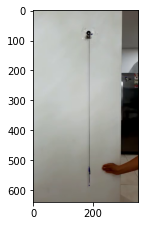

In [ ]:
figsize = tuple(map(lambda x: x / 100, video.shape[1:3]))
plt.figure(figsize=figsize)
plt.imshow(video[0,:,:,:])

# Fuerza

$F = m \text{ } a_T = -m \text{ } g$

$F = m \text{ } a_T = - m \text{ } g \text{ } sin(\theta) $

$ a_T = - \text{ } g \text{ } sin(\theta) $

# Equations

$f(t) = A cos (\omega t + \phi) $

, donde:

$\omega = \sqrt{\frac{g}{L}} $

$ g = 9.77 \frac{m}{s^2} $,

 $L = 1 m$

$A = ?$


para ángulos pequeños $\theta < 20° $, se cumple que $ sin(\theta) \approx \theta $




## Aceleración tangencial


$a_T  = -g \text{ } \theta $

$\frac{d^{2}\theta \text{ } }{dt^{2}} L = a_T$

$\frac{d^{2}\theta }{dt^{2}} = \frac{a_T}{L}$

# Posición

$\theta(t) = \theta_0 \text{ } cos (\omega t + \phi)   $ 

, donde 

$\theta_0 = 8.8 ^{\circ}$


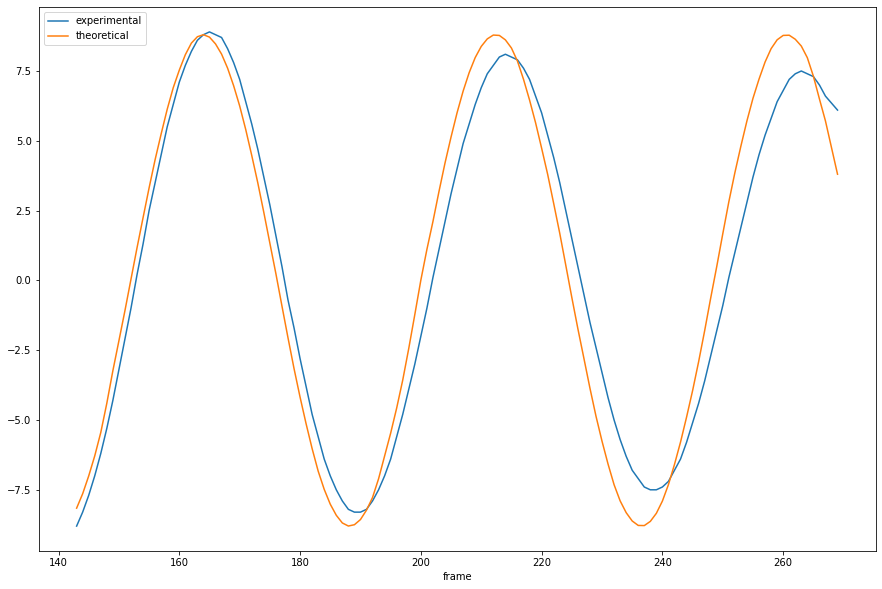

In [ ]:
g = 9.77
L = 1
omega = np.sqrt(g / L)
theta_0 = np.deg2rad(-8.8)
phi = 0
theta = lambda t : theta_0 * np.cos(omega*t + phi)
df['theta_theoretical'] = np.rad2deg(theta(df['t']))

df['angle'].plot(label='experimental', figsize=(15,10))
df['theta_theoretical'].plot(label='theoretical')
plt.legend()
plt.show()

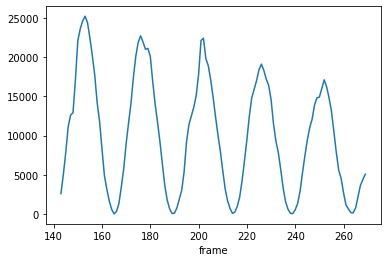

In [ ]:
df['k'].plot()

# Velocidad


$v(t) = -\theta_0 \text{ } \omega \text{ } sin (\omega t + \phi) $


# Aceleración

$a(t) = -\theta_0 \text{ } 𝞈^{2} \text{ } cos (\omega t + \phi) $ 

reorganizando tenemos 

$ a(t) = -\omega^{2} \text{ }  \theta_0 \text{ }  cos (\omega t + \phi) $

que es igual a 

$ a(t) = -\omega^{2} \text{ }  \theta(t) $

# Energías

$E_k = -\frac{1}{2} m (\theta_0 \text{ } \omega \text{ } sin(\omega t + \phi))$

cuando 

$ϴ = 0, E_K$ es máxima


La energía potencial se define como $ E_u = m \text{ } g \text{ } h$, se tiene que

donde $h = L - L cos(\theta)$

$E_u(t) = m \text{ } g \text{ } h =  m \text{ } g \text{ } L \text{ } (1 - cos(\theta(t)))$

cuando $\theta$ = $\theta_0$, $E_u$ es máxima

$E_m = E_u + E_k$


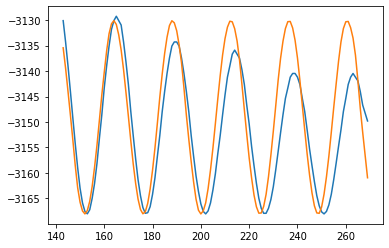

In [ ]:
eu_theoretical = m * g * L * (1 - np.rad2deg(np.cos(np.deg2rad(df['theta_theoretical']))))
plt.plot(eu_exp)
plt.plot(eu_theoretical)